# Acoustic Maze Navigation - Dataset Generation

**Goal**: Generate dataset for acoustic navigation by simulating sound propagation in mazes with proper maze generation and action labels.

## What we're doing:
1. Generate structured mazes using mazelib (Prim's algorithm)
2. Compute action labels (vector field) for supervised learning
3. Simulate sound propagation using k-Wave
4. Record full pressure time-series at ALL grid points
5. Save maze + acoustic data + labels for training

## Dataset Structure:
- **Maze grid**: Wall/air layout
- **Action grid**: Optimal move direction at each position (UP/DOWN/LEFT/RIGHT/STOP)
- **Pressure time-series**: Acoustic data at every grid point over time
- **Metadata**: Source position, resolution, frequency, etc.

In [2]:
import sys
sys.path.append('../data')

import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
from scipy import signal as scipy_signal
from scipy.fft import fft, fftfreq

# Import AudioCaveSim - the complete simulation class
import audio_cave_sim
import importlib
from audio_cave_sim import AudioCaveSim

## 1. Configuration

### Dataset Settings

In [3]:
# Dataset parameters
NUM_CAVES = 5  # Number of different cave scenes to generate
OUTPUT_DIR = Path('../dataset')
OUTPUT_DIR.mkdir(exist_ok=True)

# Grid settings (AudioCaveSim handles cave generation internally)
CAVE_SIZE = 60    # Cave dimensions (NxN grid)
RESOLUTION = 1e-2  # 1 cm resolution

print(f"Dataset Configuration:")
print(f"  Environment: CAVE (natural, irregular)")
print(f"  Scenes to generate: {NUM_CAVES}")
print(f"  Grid size: {CAVE_SIZE}x{CAVE_SIZE}")
print(f"  Resolution: {RESOLUTION*100:.1f} cm")
print(f"  Physical size: ~{CAVE_SIZE*RESOLUTION:.2f}m × {CAVE_SIZE*RESOLUTION:.2f}m")
print(f"  Output: {OUTPUT_DIR}")

Dataset Configuration:
  Environment: CAVE (natural, irregular)
  Scenes to generate: 5
  Grid size: 60x60
  Resolution: 1.0 cm
  Physical size: ~0.60m × 0.60m
  Output: ..\dataset


## 2. Generate Cave and Run Acoustic Simulation

Using AudioCaveSim which handles cave generation + k-Wave simulation

Creating AudioCaveSim (generates cave + runs k-Wave)...
end: (np.int64(51), np.int64(52))
Initializing simulation
Initializing source and sensor
Running simulation


c:\Users\danyi\repo\Audio-Maze-Navigation\.venv\Lib\site-packages\kwave\options\simulation_execution_options.py:111: UserWarning: Custom binary name set. Ignoring `is_gpu_simulation` state.
  warnings.warn("Custom binary name set. Ignoring `is_gpu_simulation` state.")


+---------------------------------------------------------------+
|                   kspaceFirstOrder-OMP v1.3                   |
+---------------------------------------------------------------+
| Reading simulation configuration:                        Done |
| Number of CPU threads:                                     20 |
| Processor name:          13th Gen Intel(R) Core(TM) i9-13900H |
+---------------------------------------------------------------+
|                      Simulation details                       |
+---------------------------------------------------------------+
| Domain dimensions:                                    80 x 80 |
| Medium type:                                               2D |
| Simulation time steps:                                  11434 |
+---------------------------------------------------------------+
|                        Initialization                         |
+---------------------------------------------------------------+
| Memory a

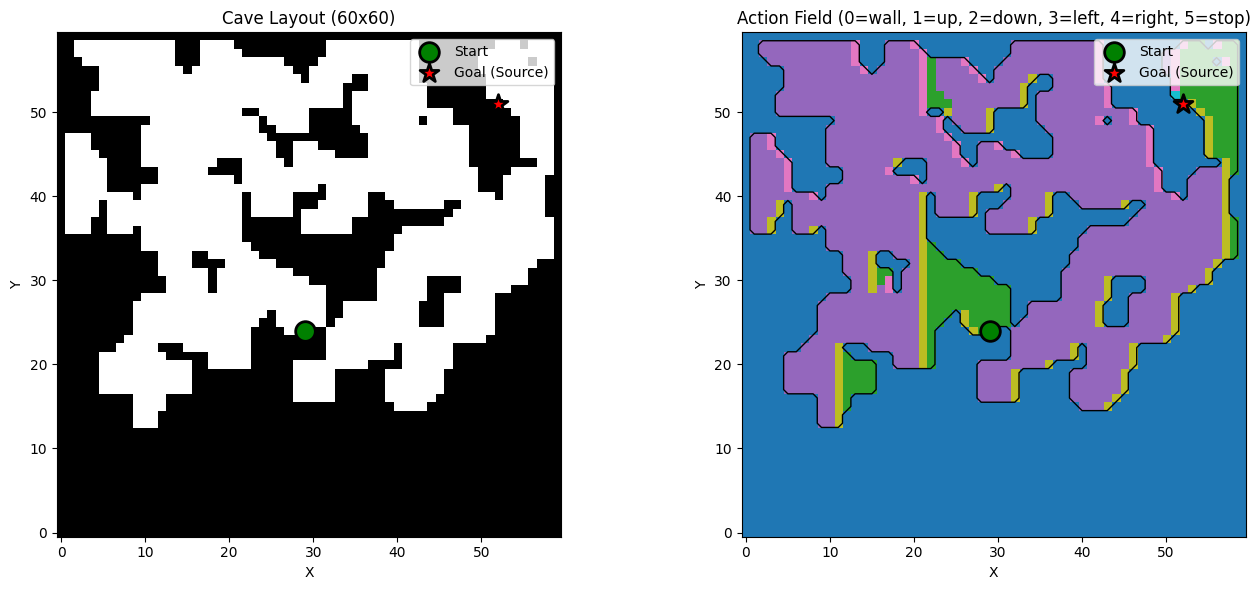

In [4]:
# Create AudioCaveSim instance
# This automatically:
# 1. Generates cave using AudioCave
# 2. Initializes k-Wave simulation
# 3. Runs the simulation
# 4. Stores all results (cave grid, action grid, sensor data)

print("Creating AudioCaveSim (generates cave + runs k-Wave)...")
print("="*70)

sim = AudioCaveSim(Nx=CAVE_SIZE, Ny=CAVE_SIZE, res=RESOLUTION)

print("="*70)
print("Simulation complete!")

# Extract data from simulation
cave = sim.am  # AudioCave instance
maze_grid = cave.grid
action_grid = np.array(cave.action_grid)
source_y, source_x = cave.end
start_y, start_x = cave.start
kgrid = sim.kgrid
sensor_data = sim.sensor_data

# Get actual dimensions
Nx, Ny = maze_grid.shape
dx = dy = RESOLUTION

print(f"\nCave Information:")
print(f"  Dimensions: {Nx}x{Ny}")
print(f"  Walls: {100*maze_grid.mean():.1f}%")
print(f"  Air: {100*(1-maze_grid.mean()):.1f}%")
print(f"  Start: ({start_y}, {start_x})")
print(f"  Goal (source): ({source_y}, {source_x})")
print(f"  Distance: {np.sqrt((start_y-source_y)**2 + (start_x-source_x)**2):.1f} cells")

air_cells = np.argwhere(maze_grid == 0)
print(f"  Navigable cells: {len(air_cells):,}")

print(f"\nSimulation Info:")
print(f"  Frequency: {sim.f0/1000:.1f} kHz")
print(f"  Duration: {sim.sim_duration*1000:.1f} ms")
print(f"  Time steps: {kgrid.Nt}")
print(f"  Pressure data shape: {sensor_data['p'].shape}")

# Visualize cave layout and action field
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cave layout
axes[0].imshow(maze_grid.T, origin='lower', cmap='binary')
axes[0].scatter([start_x], [start_y], s=200, c='green', marker='o',
               edgecolors='black', linewidths=2, label='Start', zorder=10)
axes[0].scatter([source_x], [source_y], s=200, c='red', marker='*', 
               edgecolors='black', linewidths=2, label='Goal (Source)', zorder=10)
axes[0].set_title(f'Cave Layout ({Nx}x{Ny})')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend()
axes[0].axis('image')

# Action field
symbol_map = {"up": 1, "down": 2, "left": 3, "right": 4, "stop": 5, "": 0}
action_numeric = np.vectorize(symbol_map.get)(action_grid)
axes[1].imshow(action_numeric.T, origin='lower', cmap='tab10', vmin=0, vmax=5)
axes[1].contour(maze_grid.T, levels=[0.5], colors='black', linewidths=1)
axes[1].scatter([start_x], [start_y], s=200, c='green', marker='o',
               edgecolors='black', linewidths=2, label='Start', zorder=10)
axes[1].scatter([source_x], [source_y], s=200, c='red', marker='*',
               edgecolors='black', linewidths=2, label='Goal (Source)', zorder=10)
axes[1].set_title('Action Field (0=wall, 1=up, 2=down, 3=left, 4=right, 5=stop)')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].legend()
axes[1].axis('image')

plt.tight_layout()
plt.show()

## 3. Visualize Sound Speed and Medium Properties

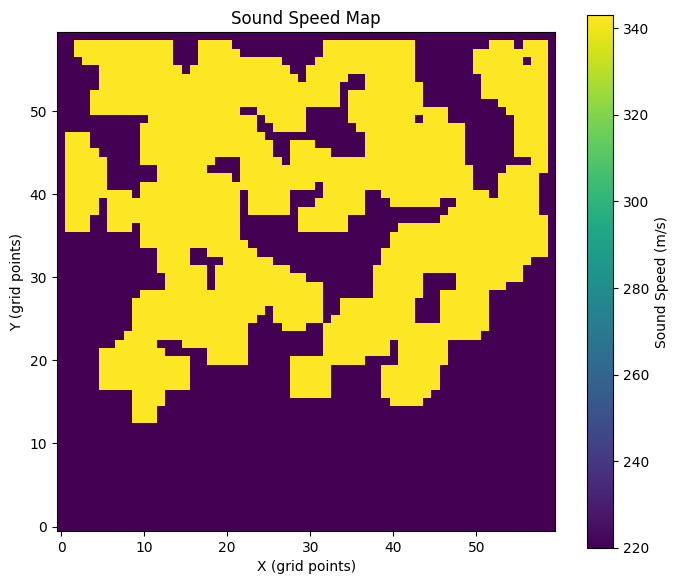

In [5]:
# Visualize sound speed map (already computed by AudioCaveSim)
sim.visualize_sound_speed()

## 4. Visualize Wave Propagation Results

Pressure field shape: (60, 60, 11434)
Final pressure range: [-0.023, 0.021]
RMS pressure range: [0.000079, 0.018531]


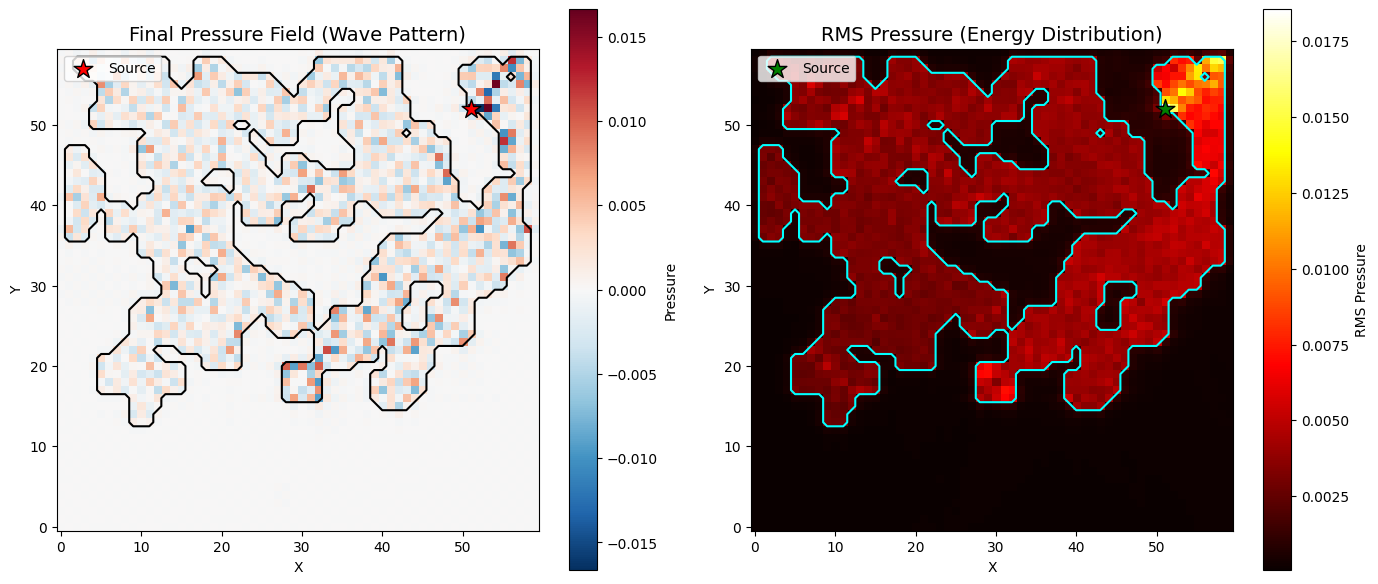

In [6]:
# Visualize wave propagation (uses internal sensor_data)
sim.visualize_wave()

## 5. Process Pressure Time-Series Data

In [7]:
# Reshape pressure time-series to 3D: (Nx, Ny, Nt)
pressure_timeseries = sensor_data['p'].T  # Shape: (Nt, Nx*Ny)
pressure_field = np.reshape(pressure_timeseries.T, (Nx, Ny, kgrid.Nt), order='C')

print(f"Pressure field shape: {pressure_field.shape}")
print(f"Pressure range: [{pressure_field.min():.3e}, {pressure_field.max():.3e}]")

# Compute p_final (last timestep) and p_rms for verification
p_final = pressure_field[:, :, -1]
p_rms = np.sqrt(np.mean(pressure_field**2, axis=2))

print(f"Final pressure range: [{p_final.min():.3f}, {p_final.max():.3f}]")
print(f"RMS pressure range: [{p_rms.min():.6f}, {p_rms.max():.6f}]")

# Check if sound reached borders
border_rms = np.concatenate([
    p_rms[0, :],   # Top
    p_rms[-1, :],  # Bottom
    p_rms[:, 0],   # Left
    p_rms[:, -1]   # Right
])

print(f"\nBorder RMS mean: {border_rms.mean():.6f}")
print(f"Border RMS max: {border_rms.max():.6f}")

if border_rms.max() > p_rms.max() * 0.01:
    print("Sound reached borders!")
else:
    print("Sound may not have reached borders")

Pressure field shape: (60, 60, 11434)
Pressure range: [-3.140e-01, 2.512e-01]
Final pressure range: [-0.022, 0.052]
RMS pressure range: [0.002194, 0.004745]

Border RMS mean: 0.002996
Border RMS max: 0.004745
Sound reached borders!


## 6. Save Dataset to HDF5

In [8]:
# Alternative: Use AudioCaveSim's built-in save method
# (saves to data_folder/ with timestamp)
# sim.save()

# Or save to dataset folder with custom format:
output_file = OUTPUT_DIR / 'acoustic_cave_dataset.h5'

with h5py.File(output_file, 'w') as f:
    # Create group for this cave
    cave_group = f.create_group('cave_0001')
    
    # Save cave structure
    cave_group.create_dataset('cave_grid', data=maze_grid, compression='gzip')
    cave_group.create_dataset('action_grid', data=action_grid.astype('S10'), compression='gzip')
    
    # Save acoustic data (time-series)
    cave_group.create_dataset('pressure_timeseries', data=pressure_field, 
                             compression='gzip', compression_opts=4)
    
    # Save metadata
    cave_group.attrs['start_position'] = [start_y, start_x]
    cave_group.attrs['source_position'] = [source_y, source_x]
    cave_group.attrs['grid_size'] = [Nx, Ny]
    cave_group.attrs['resolution_m'] = dx
    cave_group.attrs['frequency_hz'] = sim.f0
    cave_group.attrs['num_timesteps'] = kgrid.Nt
    cave_group.attrs['dt'] = kgrid.dt
    cave_group.attrs['sim_duration_s'] = sim.sim_duration
    cave_group.attrs['sound_speed_air'] = sim.c_air
    cave_group.attrs['sound_speed_wall'] = sim.c_wall

print(f"Dataset saved to {output_file}")
print(f"  File size: {output_file.stat().st_size / (1024**2):.1f} MB")
print(f"\nDataset structure:")
print(f"  cave_grid: {maze_grid.shape} - Wall/air layout")
print(f"  action_grid: {action_grid.shape} - Action labels")
print(f"  pressure_timeseries: {pressure_field.shape} - Acoustic data")
print(f"\nTo load later:")
print(f"  with h5py.File('{output_file}', 'r') as f:")
print(f"      cave_data = f['cave_0001']")
print(f"      pressure = cave_data['pressure_timeseries'][:]")

Dataset saved to ..\dataset\acoustic_cave_dataset.h5
  File size: 148.5 MB

Dataset structure:
  cave_grid: (60, 60) - Wall/air layout
  action_grid: (60, 60) - Action labels
  pressure_timeseries: (60, 60, 11434) - Acoustic data

To load later:
  with h5py.File('..\dataset\acoustic_cave_dataset.h5', 'r') as f:
      cave_data = f['cave_0001']
      pressure = cave_data['pressure_timeseries'][:]


## 7. Comprehensive Acoustic Analysis for Navigation

Extract 8-mic array and analyze for sound-based navigation

In [12]:
# Create HDF5 file for this maze
output_file = OUTPUT_DIR / 'acoustic_maze_dataset.h5'

with h5py.File(output_file, 'w') as f:
    # Create group for this maze
    maze_group = f.create_group('maze_0001')
    
    # Save maze structure
    maze_group.create_dataset('maze_grid', data=maze_grid, compression='gzip')
    maze_group.create_dataset('action_grid', data=action_grid.astype('S10'), compression='gzip')
    
    # Save acoustic data (this is the big one!)
    maze_group.create_dataset('pressure_timeseries', data=pressure_field, 
                             compression='gzip', compression_opts=4)
    
    # Save metadata
    maze_group.attrs['source_position'] = [source_y, source_x]
    maze_group.attrs['grid_size'] = [Nx, Ny]
    maze_group.attrs['resolution_m'] = dx
    maze_group.attrs['frequency_hz'] = sim.f0
    maze_group.attrs['num_timesteps'] = kgrid.Nt
    maze_group.attrs['dt'] = kgrid.dt
    maze_group.attrs['sim_duration_s'] = sim.sim_duration
    maze_group.attrs['sound_speed_air'] = 343.0
    maze_group.attrs['sound_speed_wall'] = 220.0

print(f"Dataset saved to {output_file}")
print(f"  File size: {output_file.stat().st_size / (1024**2):.1f} MB")
print(f"\nDataset structure:")
print(f"  maze_grid: {maze_grid.shape} - Wall/air layout")
print(f"  action_grid: {action_grid.shape} - Action labels")
print(f"  pressure_timeseries: {pressure_field.shape} - Acoustic data")
print(f"\nTo load later:")
print(f"  with h5py.File('{output_file}', 'r') as f:")
print(f"      maze_data = f['maze_0001']")
print(f"      pressure = maze_data['pressure_timeseries'][:]")

Dataset saved to ..\dataset\acoustic_maze_dataset.h5
  File size: 148.5 MB

Dataset structure:
  maze_grid: (60, 60) - Wall/air layout
  action_grid: (60, 60) - Action labels
  pressure_timeseries: (60, 60, 11434) - Acoustic data

To load later:
  with h5py.File('..\dataset\acoustic_maze_dataset.h5', 'r') as f:
      maze_data = f['maze_0001']
      pressure = maze_data['pressure_timeseries'][:]


## 8. Comprehensive Acoustic Analysis for Navigation

Extract 8-mic array and analyze for sound-based navigation

AGENT POSITION ANALYSIS
Agent location: (19, 52)
Optimal action: 'down'
Distance to goal: 32.0 cells

8-MIC ARRAY:
  Array shape: (8, 11434)
  Valid mics: 8/8
  Sampling rate: 114333 Hz
  Duration: 100.01 ms
  Time array shape: (11434,)
Saved comprehensive analysis to ..\dataset\acoustic_analysis.png


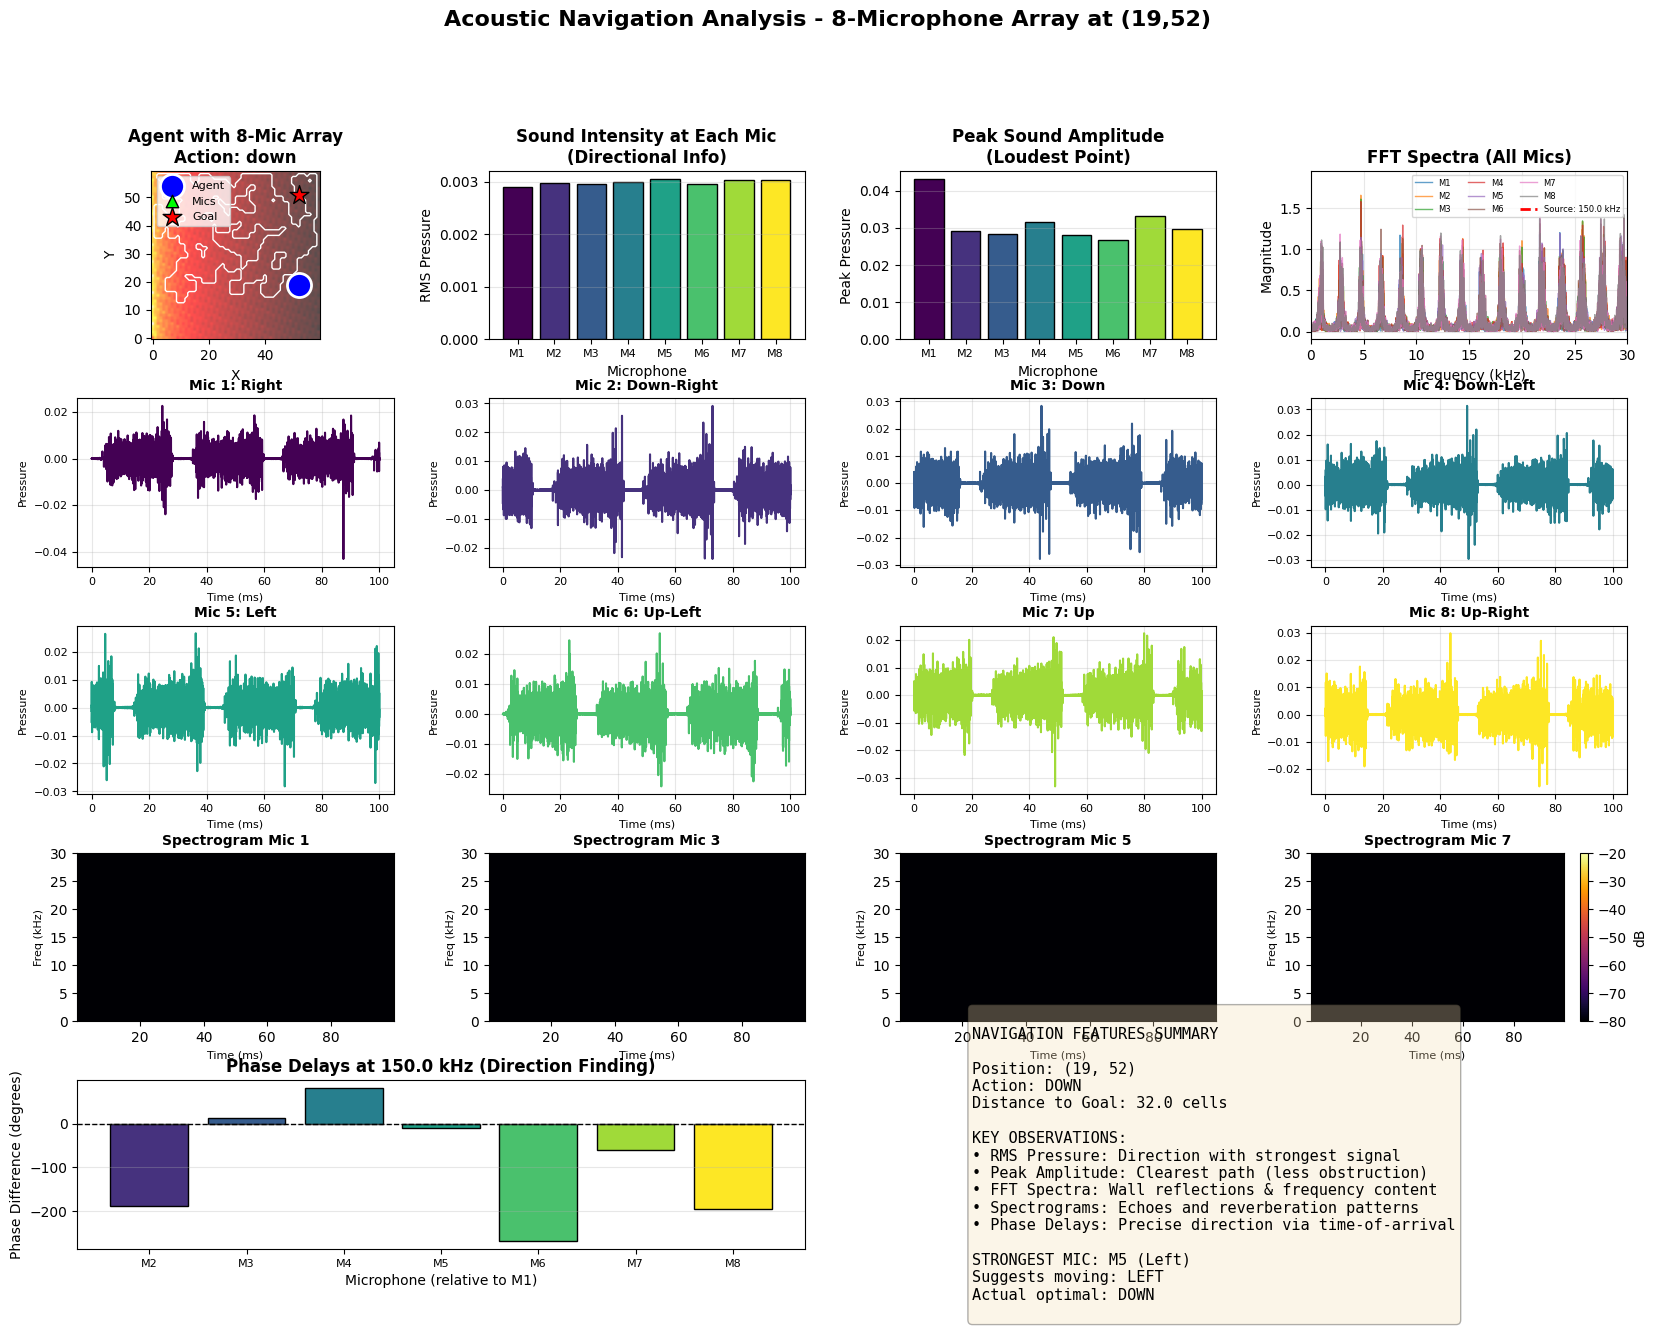

ACOUSTIC NAVIGATION FEATURES AVAILABLE:
1. RMS Pressure: Shows which direction has strongest signal
2. Peak Amplitude: Identifies clearest path (less obstruction)
3. FFT Spectra: Frequency content shows wall reflections
4. Spectrograms: Time-frequency shows echoes and reverb
5. Phase Differences: Direction finding via time-of-arrival


In [17]:
# Pick a random agent position in navigable space
air_positions = np.argwhere(maze_grid == 0)
agent_pos = air_positions[len(air_positions)//3]  # Pick a position (not goal)
agent_y, agent_x = agent_pos

print(f"AGENT POSITION ANALYSIS")
print(f"Agent location: ({agent_y}, {agent_x})")
print(f"Optimal action: '{action_grid[agent_y, agent_x]}'")
print(f"Distance to goal: {np.sqrt((agent_y - source_y)**2 + (agent_x - source_x)**2):.1f} cells")

# Define 8-mic circular array (radius = 1 grid cell)
mic_offsets = [
    (0, 1),   # Right
    (1, 1),   # Down-right
    (1, 0),   # Down
    (1, -1),  # Down-left
    (0, -1),  # Left
    (-1, -1), # Up-left
    (-1, 0),  # Up
    (-1, 1)   # Up-right
]

# Extract 8-mic time-series
mic_timeseries = []
valid_mics = []
mic_labels = ['Right', 'Down-Right', 'Down', 'Down-Left', 'Left', 'Up-Left', 'Up', 'Up-Right']

for idx, (dy, dx) in enumerate(mic_offsets):
    mic_y, mic_x = agent_y + dy, agent_x + dx
    
    if 0 <= mic_y < Ny and 0 <= mic_x < Nx and maze_grid[mic_y, mic_x] == 0:
        mic_timeseries.append(pressure_field[mic_y, mic_x, :])
        valid_mics.append((mic_y, mic_x, mic_labels[idx]))
    else:
        # Fallback to agent position if mic in wall
        mic_timeseries.append(pressure_field[agent_y, agent_x, :])
        valid_mics.append((agent_y, agent_x, mic_labels[idx] + " (fallback)"))

mic_timeseries = np.array(mic_timeseries)  # Shape: (8, Nt)

# Create time array (flatten if needed)
time_array = np.asarray(kgrid.t_array).flatten() * 1000  # Convert to ms

print(f"\n8-MIC ARRAY:")
print(f"  Array shape: {mic_timeseries.shape}")
print(f"  Valid mics: {len([m for m in valid_mics if 'fallback' not in m[2]])}/8")
print(f"  Sampling rate: {1/kgrid.dt:.0f} Hz")
print(f"  Duration: {kgrid.Nt * kgrid.dt * 1000:.2f} ms")
print(f"  Time array shape: {time_array.shape}")
print(f"="*70)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(5, 4, hspace=0.35, wspace=0.3)

# Row 0: Overview
# 1. Agent Position in Cave
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(p_rms.T, origin='lower', cmap='hot', alpha=0.7)
ax1.contour(maze_grid.T, levels=[0.5], colors='white', linewidths=1)
ax1.scatter([agent_x], [agent_y], s=300, c='blue', marker='o', 
           edgecolors='white', linewidths=2, label='Agent', zorder=10)
mic_xs = [m[1] for m in valid_mics]
mic_ys = [m[0] for m in valid_mics]
ax1.scatter(mic_xs, mic_ys, s=80, c='lime', marker='^',
           edgecolors='black', linewidths=1, label='Mics', zorder=9)
ax1.scatter([source_x], [source_y], s=200, c='red', marker='*',
           edgecolors='black', linewidths=1, label='Goal', zorder=10)
ax1.set_title(f'Agent with 8-Mic Array\nAction: {action_grid[agent_y, agent_x]}', fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend(fontsize=8)
ax1.axis('image')

# 2. RMS Pressure at Each Mic (shows directionality)
ax2 = fig.add_subplot(gs[0, 1])
mic_rms = np.sqrt(np.mean(mic_timeseries**2, axis=1))
colors = plt.cm.viridis(np.linspace(0, 1, 8))
bars = ax2.bar(range(8), mic_rms, color=colors, edgecolor='black', linewidth=1)
ax2.set_xlabel('Microphone')
ax2.set_ylabel('RMS Pressure')
ax2.set_title('Sound Intensity at Each Mic\n(Directional Info)', fontsize=12, fontweight='bold')
ax2.set_xticks(range(8))
ax2.set_xticklabels([f'M{i+1}' for i in range(8)], fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Peak Pressure (Max Amplitude)
ax3 = fig.add_subplot(gs[0, 2])
mic_peak = np.max(np.abs(mic_timeseries), axis=1)
bars = ax3.bar(range(8), mic_peak, color=colors, edgecolor='black', linewidth=1)
ax3.set_xlabel('Microphone')
ax3.set_ylabel('Peak Pressure')
ax3.set_title('Peak Sound Amplitude\n(Loudest Point)', fontsize=12, fontweight='bold')
ax3.set_xticks(range(8))
ax3.set_xticklabels([f'M{i+1}' for i in range(8)], fontsize=8)
ax3.grid(True, alpha=0.3, axis='y')

# 4. FFT Spectra for all mics
ax4 = fig.add_subplot(gs[0, 3])
for i in range(8):
    fft_vals = fft(mic_timeseries[i, :])
    freqs = fftfreq(len(mic_timeseries[i, :]), kgrid.dt)
    pos_mask = freqs > 0
    freqs_pos = freqs[pos_mask]
    fft_mag = np.abs(fft_vals[pos_mask])
    ax4.plot(freqs_pos / 1000, fft_mag, label=f'M{i+1}', alpha=0.7, linewidth=1)
ax4.set_xlabel('Frequency (kHz)', fontsize=10)
ax4.set_ylabel('Magnitude', fontsize=10)
ax4.set_title('FFT Spectra (All Mics)', fontsize=12, fontweight='bold')
ax4.set_xlim([0, 30])
ax4.axvline(sim.f0/1000, color='red', linestyle='--', linewidth=2, label=f'Source: {sim.f0/1000:.1f} kHz')
ax4.legend(fontsize=6, ncol=3)
ax4.grid(True, alpha=0.3)

# Row 1-2: Time Series for Mics 1-4
for i in range(4):
    ax = fig.add_subplot(gs[1, i])
    ax.plot(time_array, mic_timeseries[i, :], linewidth=1.5, color=colors[i])
    ax.set_title(f'Mic {i+1}: {mic_labels[i]}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (ms)', fontsize=8)
    ax.set_ylabel('Pressure', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Row 2: Time Series for Mics 5-8
for i in range(4, 8):
    ax = fig.add_subplot(gs[2, i-4])
    ax.plot(time_array, mic_timeseries[i, :], linewidth=1.5, color=colors[i])
    ax.set_title(f'Mic {i+1}: {mic_labels[i]}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (ms)', fontsize=8)
    ax.set_ylabel('Pressure', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Row 3: Spectrograms for 4 mics
for idx, mic_idx in enumerate([0, 2, 4, 6]):  # Mics 1, 3, 5, 7
    ax = fig.add_subplot(gs[3, idx])
    f_spec, t_spec, Sxx = scipy_signal.spectrogram(mic_timeseries[mic_idx, :], fs=1/kgrid.dt,
                                                    nperseg=min(64, len(mic_timeseries[mic_idx, :])))
    pcm = ax.pcolormesh(t_spec * 1000, f_spec / 1000, 10 * np.log10(Sxx + 1e-10), 
                        shading='gouraud', cmap='inferno', vmin=-80, vmax=-20)
    ax.set_ylabel('Freq (kHz)', fontsize=8)
    ax.set_xlabel('Time (ms)', fontsize=8)
    ax.set_title(f'Spectrogram Mic {mic_idx+1}', fontsize=10, fontweight='bold')
    ax.set_ylim([0, 30])
    if idx == 3:
        plt.colorbar(pcm, ax=ax, label='dB')

# Row 4: Phase Analysis and Summary
# Phase Differences (relative to Mic 1)
ax_phase = fig.add_subplot(gs[4, 0:2])
phase_diffs = []
for i in range(1, 8):
    fft1 = fft(mic_timeseries[0, :])
    fft_i = fft(mic_timeseries[i, :])
    freq_idx = np.argmin(np.abs(fftfreq(len(mic_timeseries[0, :]), kgrid.dt) - sim.f0))
    phase_diff = np.angle(fft_i[freq_idx]) - np.angle(fft1[freq_idx])
    phase_diffs.append(np.degrees(phase_diff))
ax_phase.bar(range(1, 8), phase_diffs, color=colors[1:], edgecolor='black', linewidth=1)
ax_phase.set_xlabel('Microphone (relative to M1)', fontsize=10)
ax_phase.set_ylabel('Phase Difference (degrees)', fontsize=10)
ax_phase.set_title(f'Phase Delays at {sim.f0/1000:.1f} kHz (Direction Finding)', fontsize=12, fontweight='bold')
ax_phase.set_xticks(range(1, 8))
ax_phase.set_xticklabels([f'M{i+1}' for i in range(1, 8)], fontsize=8)
ax_phase.axhline(0, color='black', linestyle='--', linewidth=1)
ax_phase.grid(True, alpha=0.3, axis='y')

# Summary Text
ax_text = fig.add_subplot(gs[4, 2:])
ax_text.axis('off')
summary_text = f"""
NAVIGATION FEATURES SUMMARY

Position: ({agent_y}, {agent_x})
Action: {action_grid[agent_y, agent_x].upper()}
Distance to Goal: {np.sqrt((agent_y-source_y)**2 + (agent_x-source_x)**2):.1f} cells

KEY OBSERVATIONS:
• RMS Pressure: Direction with strongest signal
• Peak Amplitude: Clearest path (less obstruction)
• FFT Spectra: Wall reflections & frequency content
• Spectrograms: Echoes and reverberation patterns
• Phase Delays: Precise direction via time-of-arrival

STRONGEST MIC: M{np.argmax(mic_rms)+1} ({mic_labels[np.argmax(mic_rms)]})
Suggests moving: {mic_labels[np.argmax(mic_rms)].upper()}
Actual optimal: {action_grid[agent_y, agent_x].upper()}
"""
ax_text.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Acoustic Navigation Analysis - 8-Microphone Array at ({agent_y},{agent_x})',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig(OUTPUT_DIR / 'acoustic_analysis.png', dpi=150, bbox_inches='tight')
print(f"Saved comprehensive analysis to {OUTPUT_DIR / 'acoustic_analysis.png'}")
plt.show()


print("ACOUSTIC NAVIGATION FEATURES AVAILABLE:")
print(f"1. RMS Pressure: Shows which direction has strongest signal")
print(f"2. Peak Amplitude: Identifies clearest path (less obstruction)")
print(f"3. FFT Spectra: Frequency content shows wall reflections")
print(f"4. Spectrograms: Time-frequency shows echoes and reverb")
print(f"5. Phase Differences: Direction finding via time-of-arrival")